
This uses the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [1]:
# Science imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default. 
sns.set_style("darkgrid") # set a grey grid as a background

# ML imports
import sklearn
from sklearn import metrics
# Linear Regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Logistic Regression
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### Importing yelp data from a csv

**Read the yelp.csv file and set it as a dataframe called yelp.**

In [3]:
yelp = pd.read_csv("yelp.csv")

**Exploratory DataFrame Analysis**

In [4]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [6]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Create a new column called "text length" which is the number of words in the text column.**

In [8]:
yelp['text length'] = yelp['text'].apply(len)

In [9]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


## Exporatory Data Analysis using Seaborn


**Using FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings.**

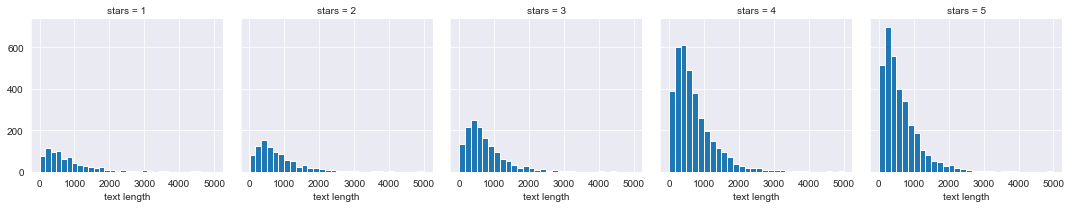

In [14]:
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length',bins=30)

**Creating a boxplot of text length for each star category.**

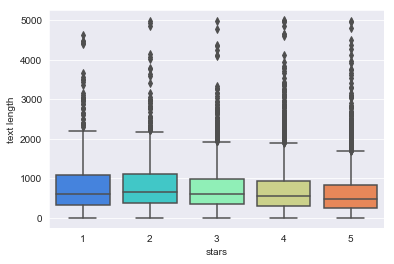

In [17]:
sns.boxplot(x='stars',y='text length',data=yelp, palette='rainbow')

**Creating a countplot of the number of occurrences for each type of star rating.**

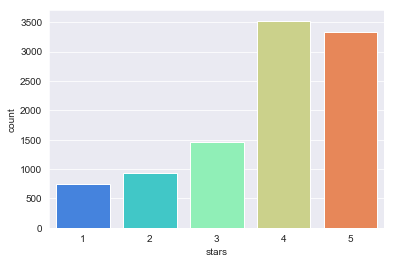

In [21]:
sns.countplot(x='stars',data=yelp,palette='rainbow')

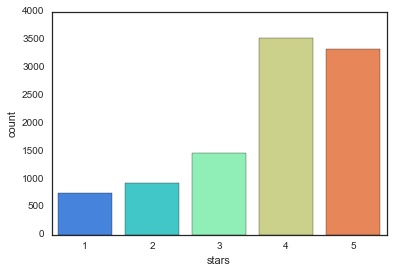

In [104]:
sns.countplot(x='stars',y=yelp['stars'].count())

**Using groupby to get the mean values of the numerical columns**

In [22]:
yelp.groupby('stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Using the corr() method on that groupby dataframe to produce this dataframe:**

In [23]:
yelp.groupby('stars').mean().corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

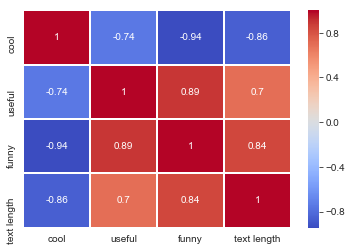

In [31]:
sns.heatmap(yelp.groupby('stars').mean().corr(),cmap='coolwarm',linewidth=1,annot=True)

## Classifying with NLP

 Get only reviews that were either 1 star or 5 stars.

**Creating a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [36]:
yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5) ]

In [37]:
yelp_class.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345


** Create two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (Your features and target/labels)**

In [49]:
X=yelp_class['text']
y=yelp_class['stars']

**Creating a CountVectorizer object.**

In [50]:
cv = CountVectorizer()
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

** Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). Save this result by overwriting X.**

In [51]:
X = cv.fit_transform(X)

### The Train Test Split step

**spliting up the data into X_train, X_test, y_train, y_test. Use test_size=0.3 and random_state=101**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Training the Model

**creating an instance of the estimator**

In [53]:
nb = MultinomialNB()

**fitting nb using the training data.**

In [54]:
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Making Predictions and Evaluating

In [55]:
predictions = nb.predict(X_test)

**Adding a confusion matrix and classification report using these predictions and y_test**

In [56]:
print(classification_report(y_test,predictions))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

   micro avg       0.93      0.93      0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



Confusion Matrix
[[159  69]
 [ 22 976]]


[[159  69]
 [ 22 976]]


             precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



### Using Text Processing

**including TF-IDF to this process using a pipeline.**

**creating a pipeline with the following steps:CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [81]:
pipeline2 = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

### Using the Pipeline

**The pipeline has all the pre-process steps in it already, so re-spliting the original data**

### Train Test Split

**Redo the train test split on the yelp_class object.**

In [82]:
X2=yelp_class['text']
y2=yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=101)

**Now fit the pipeline to the training data. Remember you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels**

In [83]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### Predictions and Evaluation

**Using the pipeline to predict from the X_test and create a classification report and confusion matrix.**

In [84]:
predictions2 = pipeline.predict(X_test)

In [80]:
print(classification_report(y_test,predictions1))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions1))

              precision    recall  f1-score   support

           1       0.82      0.43      0.56       228
           5       0.88      0.98      0.93       998

   micro avg       0.88      0.88      0.88      1226
   macro avg       0.85      0.70      0.74      1226
weighted avg       0.87      0.88      0.86      1226



Confusion Matrix
[[ 97 131]
 [ 22 976]]


In [85]:
print(classification_report(y_test,predictions2))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions2))

              precision    recall  f1-score   support

           1       0.88      0.37      0.52       228
           5       0.87      0.99      0.93       998

   micro avg       0.87      0.87      0.87      1226
   macro avg       0.87      0.68      0.73      1226
weighted avg       0.87      0.87      0.85      1226



Confusion Matrix
[[ 85 143]
 [ 12 986]]


**Notice that Tf-Idf actually gave worse predictions**